# ActBlue basic details

In [4]:
import json
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os
import requests

In [26]:
%matplotlib inline

plt.style.use('ggplot')

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def read_or_save(name, func):
    path = 'pickles/' + name + '.pickle.gz'
    if (os.path.isfile(path)):
        return pd.read_pickle(path)
    else:
        result = func()
        os.makedirs('pickles', exist_ok=True)
        result.to_pickle(path)
        return result

In [6]:
committee_id = "C00401224"
year_since = 2013

### Connect to the PostgreSQL database

In [8]:
with open("config.json") as f:
    conf = json.load(f)
conn = psycopg2.connect(
    dbname=conf['dbname'],
    user=conf['user'],
    host=conf['host'],
    password=conf['password']
)

### How many reports are in the database?

In [30]:
read_or_save(
    'filings_count',
    lambda: pd.read_sql("""
    SELECT count(*)
    FROM fec_filings;
    """, con=conn)
)

,count
0,296120


### Which ActBlue reports do we have?

In [31]:
actblue_summaries = read_or_save(
    'actblue_summaries',
    lambda: pd.read_sql("""
    SELECT *
    FROM fec_pac_summaries
    JOIN fec_amended_filings USING (filing_id)
    WHERE filer_committee_id_number = '""" + committee_id + """'
    AND extract(year from coverage_through_date) > """ + str(year_since) + """
    ORDER BY coverage_through_date DESC;
    """, con=conn, parse_dates={
        'coverage_from_date': '%Y-%m-%d',
        'coverage_through_date': '%Y-%m-%d'
    })
)

actblue_summaries[[
    'filing_id',
    'form_type',
    'committee_name',
    'coverage_from_date',
    'coverage_through_date',
    'report_code',
    'col_a_total_contributions'
]]

,filing_id,form_type,committee_name,coverage_from_date,coverage_through_date,report_code,col_a_total_contributions
0,1233520,F3XN,ActBlue,2018-04-01,2018-04-30,M5,"38,328,646.45"
1,1225971,F3XN,ActBlue,2018-03-01,2018-03-31,M4,"57,825,086.02"
2,1215697,F3XN,ActBlue,2018-02-01,2018-02-28,M3,"41,932,847.30"
3,1224404,F3XA,ActBlue,2018-01-01,2018-01-31,M2,"32,937,704.67"
4,1224416,F3XA,ActBlue,2017-12-01,2017-12-31,YE,"51,181,861.72"
5,1219434,F3XA,ActBlue,2017-11-01,2017-11-30,M12,"36,180,318.82"
6,1219420,F3XA,ActBlue,2017-10-01,2017-10-31,M11,"29,341,844.16"
7,1218757,F3XA,ActBlue,2017-09-01,2017-09-30,M10,"34,193,318.59"
8,1217404,F3XA,ActBlue,2017-08-01,2017-08-31,M9,"22,119,367.28"
9,1217370,F3XA,ActBlue,2017-07-01,2017-07-31,M8,"19,876,390.23"


### Are there any reports that FEC.gov has that we don't or vice versa?

In [32]:
def get_reports(committee_id):
    base = "https://api.open.fec.gov/v1/"
    url = base + "committee/" + committee_id + "/reports/?api_key=" + conf['fec_key'] + "&is_amended=False&per_page=100"

    return pd.DataFrame(requests.get(url).json()['results'])

actblue_api_summaries = read_or_save('actblue_api_summaries', lambda: get_reports(committee_id))
pd.to_numeric(actblue_api_summaries['calendar_ytd'])
actblue_api_summaries = actblue_api_summaries[actblue_api_summaries['calendar_ytd'] > year_since]
actblue_api_summaries[['file_number','calendar_ytd']]

pd.DataFrame(pd.concat([actblue_api_summaries['file_number'],
                        actblue_summaries['filing_id']]).drop_duplicates(keep=False))

,0


### How have contributions changed over time?

Text(0.5,1,'Total contributions by reporting period')

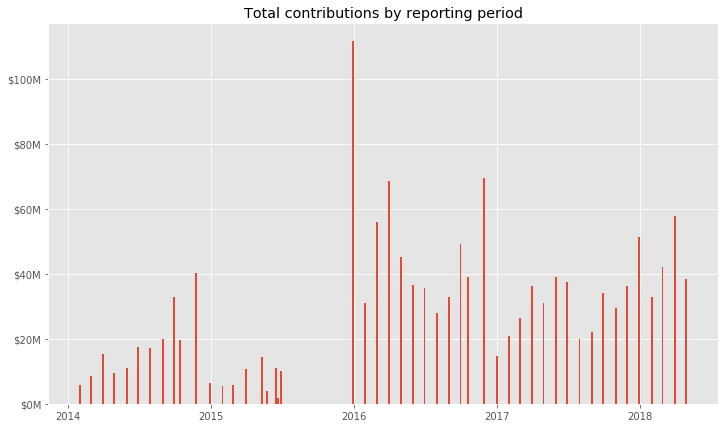

In [33]:
contribs_over_time = actblue_summaries[['coverage_through_date','col_a_total_contributions']]

# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
contribs_over_time.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(12,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_over_time.index, contribs_over_time['col_a_total_contributions'], width=5)

ax.set_title('Total contributions by reporting period')

In [34]:
contribs_by_year = pd.DataFrame(
    actblue_summaries.groupby(actblue_summaries.coverage_through_date.dt.year)['col_a_total_contributions'].sum()
)
contribs_by_year

,col_a_total_contributions
coverage_through_date,
2014,"203,718,311.99"
2015,"174,548,526.96"
2016,"505,359,517.22"
2017,"383,829,198.73"
2018,"171,024,284.44"


Text(0.5,1,'Total contributions by year')

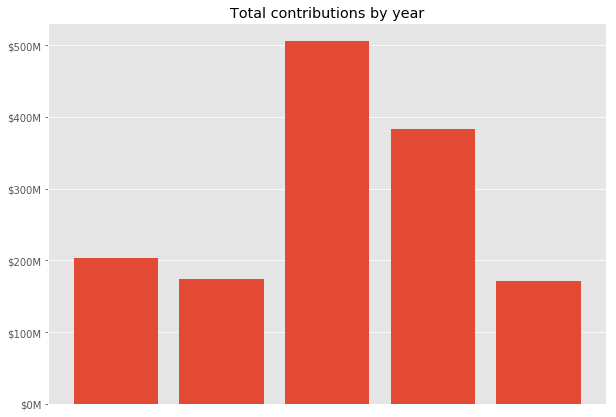

In [35]:
# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
# contribs_by_year.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(10,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_by_year.index, contribs_by_year['col_a_total_contributions'], width=0.8)

ax.set_title('Total contributions by year')

### How many Democratic campaigns use ActBlue?

In [36]:
actblue_transfers = read_or_save(
    'actblue_transfers',
    lambda: pd.read_sql("""
    SELECT fec_committees.name,
           totals.*
    FROM
      (SELECT beneficiary_committee_fec_id,
              count(*),
              sum(expenditure_amount)
       FROM fec_expenditures
       WHERE filing_id IN
           (SELECT filing_id
            FROM fec_pac_summaries
            JOIN fec_amended_filings USING (filing_id)
            WHERE filer_committee_id_number = '""" + committee_id + """'
              AND extract(YEAR
                          FROM coverage_through_date) > """ + str(year_since) + """
            ORDER BY coverage_through_date DESC)
         AND form_type = 'SB23'
       GROUP BY beneficiary_committee_fec_id) AS totals
    JOIN fec_committees ON beneficiary_committee_fec_id = fec_committees.id
    """, con=conn)
)
actblue_transfers.sort_values(by=['sum'], ascending=False)

,name,beneficiary_committee_fec_id,count,sum
3161,DCCC,C00000935,9082749,"188,248,398.32"
1622,BERNIE 2016,C00577130,6955993,"180,898,812.29"
617,DSCC,C00042366,2731506,"76,723,047.25"
906,END CITIZENS UNITED,C00573261,3070095,"41,635,775.57"
900,JON OSSOFF FOR CONGRESS,C00630426,1430332,"27,468,759.69"
510,DOUG JONES FOR SENATE COMMITTEE,C00640623,737861,"21,480,552.48"
836,PROGRESSIVE TURNOUT PROJECT,C00580068,1152401,"15,591,855.91"
975,GILLIBRAND FOR SENATE,C00413914,329058,"12,768,170.63"
525,CHC BOLD PAC,C00365536,820192,"10,976,666.17"
1538,DNC SERVICES CORP./DEM. NAT'L COMMITTEE,C00010603,503743,"10,197,737.97"


In [66]:
actblue_proportion = read_or_save(
    'actblue_proportion',
    lambda: pd.read_sql("""
    SELECT actblue,
           count(*)
    FROM
      (SELECT cand_id,
              cand_pcc,
              CASE
                  WHEN COUNT IS NOT NULL THEN TRUE
                  ELSE FALSE
              END AS actblue
       FROM fec_candidates
       LEFT JOIN
         (SELECT fec_committees.name,
                 totals.*
          FROM
            (SELECT beneficiary_committee_fec_id,
                    count(*) AS COUNT,
                    sum(expenditure_amount)
             FROM fec_expenditures
             WHERE filing_id IN
                 (SELECT filing_id
                  FROM fec_pac_summaries
                  JOIN fec_amended_filings USING (filing_id)
                  WHERE filer_committee_id_number = '""" + committee_id + """'
                    AND extract(YEAR
                                FROM coverage_through_date) >= 2017
                  ORDER BY coverage_through_date DESC)
               AND form_type = 'SB23'
             GROUP BY beneficiary_committee_fec_id) AS totals
          JOIN fec_committees ON beneficiary_committee_fec_id = fec_committees.id) AS actblue_committees ON cand_pcc = beneficiary_committee_fec_id
       WHERE cand_election_yr = '2018'
         AND cand_pty_affiliation IN ('DFL',
                                      'DEM')
         AND cand_pcc IS NOT NULL) AS actblue_candidates
    GROUP BY actblue
    """, con=conn)
)

actblue_proportion

,actblue,count
0,False,262
1,True,1307


In [9]:
actblue_proportion_amount = read_or_save(
    'actblue_proportion_amount',
    lambda: pd.read_sql("""
    SELECT cand_pcc,
           coverage_through_date,
           col_a_total_receipts,
           sum(expenditure_amount) AS total
    FROM
      (SELECT DISTINCT ON (cand_id,
                           cand_pcc) cand_id,
                          cand_pcc,
                          coverage_from_date,
                          coverage_through_date,
                          col_a_total_receipts
       FROM fec_candidates
       JOIN fec_campaign_summaries ON cand_pcc = filer_committee_id_number
       JOIN fec_amended_filings USING (filing_id)
       WHERE cand_election_yr = '2018'
         AND cand_pty_affiliation IN ('DFL',
                                      'DEM')
         AND extract(YEAR
                     FROM coverage_through_date) > 2016
         AND cand_office = 'H'
         AND cand_pcc IS NOT NULL
       ORDER BY cand_id,
                cand_pcc,
                coverage_from_date DESC, coverage_through_date DESC) AS candidate_totals
    LEFT JOIN fec_expenditures ON filing_id IN
      (SELECT filing_id
       FROM fec_pac_summaries
       JOIN fec_amended_filings USING (filing_id)
       WHERE filer_committee_id_number = '""" + committee_id + """'
         AND extract(YEAR
                     FROM coverage_through_date) >= 2016
       ORDER BY coverage_through_date DESC)
    AND form_type = 'SB23'
    AND beneficiary_committee_fec_id = cand_pcc
    AND coverage_from_date <= expenditure_date
    AND coverage_through_date >= expenditure_date
    GROUP BY cand_pcc,
             coverage_through_date,
             col_a_total_receipts
    """, con=conn)
)

actblue_proportion_amount

,cand_pcc,coverage_through_date,col_a_total_receipts,total
0,C00637728,2018-03-31,1375.00,1250.00
1,C00422980,2018-03-31,42555.00,53.89
2,C00662866,2018-03-31,65944.08,33723.00
3,C00674788,2018-03-31,10797.86,3438.00
4,C00655035,2018-03-31,3630.00,5.00
5,C00639658,2018-03-31,2070.00,NaN
6,C00659565,2018-05-23,15619.95,1420.00
7,C00663468,2018-04-15,420.00,420.00
8,C00652321,2018-05-23,18244.86,1864.50
9,C00653816,2018-05-23,138635.52,36063.70


### Questions to answer
> - What percent of Democratic candidate dollars so far this cycle have come through ActBlue?
> - Are Republican groups reporting any small donor data that we could analyze in a valid way, or is that just impossible?
> - Is this fueling primary fights?
